In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *
from qiskit import IBMQ

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 2
numQubit = 1
global iterations
global noisy

In [5]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 12):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [4.5580876,  2.27683802, 3.20897343, 4.75284933, 5.72040349, 5.73777619,
                   5.36258279, 5.88041593, 1.88422587, 5.78826696, 1.61777086, 0.45474405]

In [6]:
print(unitary_param_1)

[4.5580876, 2.27683802, 3.20897343, 4.75284933, 5.72040349, 5.73777619, 5.36258279, 5.88041593, 1.88422587, 5.78826696, 1.61777086, 0.45474405]


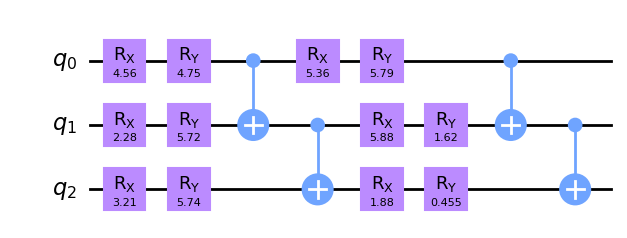

In [7]:
# First unitary
size = 3
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [9]:
def createEqSuperpos2BE():
    temp = QuantumCircuit(1)
    temp.h(0)
    return temp

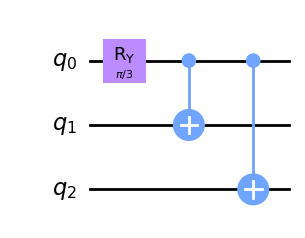

In [59]:
qcTest = QuantumCircuit(3)
qcTest.ry(np.pi/3, 0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)
qcTest.draw('mpl')

In [60]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(4)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperpos2BE()
    circ.append(superPosCircuit, [0])

    circ.append(state, [1, 2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3])
    
    circ.cswap(0, 2, 3)
    
    circ.append(superPosCircuit.inverse(), [0])
    
    return circ

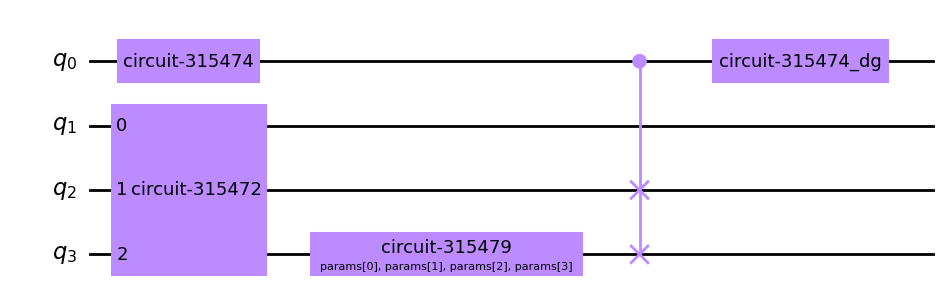

In [61]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [62]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [63]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [64]:
#Create Hamiltonian here
hamiltonian = I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))

In [65]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [66]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [67]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [68]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [69]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[4.56951413 1.2996747  5.10383396 5.9228751 ]
Initial Cost :  0.5204570307490619


In [70]:
true_value = 1.0

In [71]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5204570307490619
Loss Value :  0.5769363417384028 1.0%
Loss Value :  0.8289938419800214 2.0%
Loss Value :  0.8320595561535991 3.0%
Loss Value :  0.8320836415879839 4.0%
Loss Value :  0.8346053145692279 5.0%
Loss Value :  0.8685896799044137 6.0%
Loss Value :  0.9849216631035994 7.0%
Loss Value :  0.9784100837467988 8.0%
Loss Value :  0.9814175335309989 9.0%
Loss Value :  0.9940518317520127 10.0%
Loss Value :  0.9993569605573253 11.0%
Loss Value :  0.999355925413289 12.0%
Loss Value :  0.9993545973866218 13.0%
Loss Value :  0.9995549451630888 14.0%
Loss Value :  0.9996672349731265 15.0%
Loss Value :  0.9999551311161673 16.0%
Loss Value :  0.9999799023286999 17.0%
Loss Value :  0.9999557685177851 18.0%
Loss Value :  0.999953748686927 19.0%
Loss Value :  0.9999370488846104 20.0%
Loss Value :  0.999923727589755 21.0%
Loss Value :  0.9999222422544594 22.0%
Loss Value :  0.9999673673057731 23.0%
Loss Value :  0.9999680444602186 24.0%
Loss Value :  0.9999987922192282 25.0%
Lo

In [72]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.5210613139877722
Loss Value :  0.5401316876744494 1.0%
Loss Value :  0.5542500709974706 2.0%
Loss Value :  0.8376212804970756 3.0%
Loss Value :  0.8819750754427893 4.0%
Loss Value :  0.9464501398862317 5.0%
Loss Value :  0.9505284504011189 6.0%
Loss Value :  0.9548625977345515 7.0%
Loss Value :  0.9585072401393435 8.0%
Loss Value :  0.9558506386482973 9.0%
Loss Value :  0.9365870734133576 10.0%
Loss Value :  0.9412387731727213 11.0%
Loss Value :  0.9630774391195895 12.0%
Loss Value :  0.9715327677438449 13.0%
Loss Value :  0.9656738120729002 14.0%
Loss Value :  0.9452908015076118 15.0%
Loss Value :  0.9644860668561717 16.0%
Loss Value :  0.9451827445554467 17.0%
Loss Value :  0.9391300569858494 18.0%
Loss Value :  0.9281907129548442 19.0%
Loss Value :  0.9332477726124102 20.0%
Loss Value :  0.9546237197402266 21.0%
Loss Value :  0.9642125276038331 22.0%
Loss Value :  0.9574267867186297 23.0%
Loss Value :  0.961303227681532 24.0%
Loss Value :  0.9580004047311115 25.0%


In [73]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9995263094711919


In [74]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.9999958107700686
Noisy :  0.9583956698651962
Noise Resilient Value :  0.9995263094711919


In [75]:
def writeToFile():
    file = open("S2_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [76]:
writeToFile()